# Elevators and Generators

> We use Python generators to simulate elevators in a residential building.

- toc: true
- branch: master
- badges: false
- comments: true
- categories: [python, simulation]
- image: images/spectral_coclustering_opening.png
- hide: false
- search_exclude: false
- annotations: true

Recently I moved to an apartment building. While waiting for the elevator one morning, I started thinking about writing a simplified event-based elevator simulation. Below I describe my attempt.

## First, definitions and concepts

Why would we want to use generators to model elevators? From the Python docs:

> Generator: A function which contains yield expression. Each yield temporarily suspends processing, remembering the location execution state (including local variables and pending try-statements). When the generator iterator resumes, **it picks up where it left off**

You can see that the feature of "picks up where it left off" can be particularly useful when modeling elevators (and other event-based systems).

### Concept inventory

* elevator
* elevator group
* group of people - RENAME!

In [58]:
from collections import namedtuple
from queue import PriorityQueue

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
# passenger priority is given by arrival time
Passenger = namedtuple('Passenger', ['arrival_time', 'id', 'start_level', 'end_level'])
Journey = namedtuple('Journey', ['elev_id', 'passenger_id', 'time_pickup', 'travel_time'])
ElevReady = namedtuple('ElevReady', ['ready_time', 'elev_id', 'level'])

FIXED_TIME = 15 # [s] time for each pickup
SAME_FLOOR_TIME = 5  # [s]
LEVEL_TIME = 0.5 # [s / level]
TOP_LEVEL = 40

def elev_time(start, end):
    if start == end:
        return SAME_FLOOR_TIME
    return abs(end - start) * LEVEL_TIME + FIXED_TIME

def elevator(elev_id, level=1):
    journey = None
    while True:
        group = yield journey
        time_pickup = elev_time(level, group.start_level)
        travel_time = elev_time(group.start_level, group.end_level)
        journey = Journey(elev_id, group.id, time_pickup, travel_time)
        level = group.end_level  # elevator waits at destination

class ElevGroup:
    """A group of elevators."""
    def __init__(self, n_elevs, elevator):
        assert n_elevs >= 1, 'Need at least one elevator.'
        self.elevs = {i: elevator(i) for i in range(n_elevs)}
        # at t = 0 all elevators are ready at floor = 1
        self.elevs_ready = [ElevReady(0, i, 1) for i in range(n_elevs)]
        for elev in self.elevs.values(): next(elev)  # prime generators
            
    def ready_for_passenger(self, passenger):
        return [r for r in self.elevs_ready if passenger.arrival_time >= r.ready_time]
     
    def dispatch_elev(self, passenger):
        """Get the next elevator for a given passenger.
        If more than one elevators are available, use the one closest to the passenger.
        
        Returns:
        The ElevReady event and corresponding elevator.
        """
        ready_elevs = self.ready_for_passenger(passenger)
        if ready_elevs:
            # pick the one closest to passenger.start_level
            def level_dist(elev_ready):
                return abs(elev_ready.level - passenger.start_level)
            ready_event = min(ready_elevs, key=level_dist)
        else:
            ready_event = min(self.elevs_ready, key=lambda r: r.ready_time)
        
        self.elevs_ready.remove(ready_event)
        return ready_event, self.elevs[ready_event.elev_id]

    def move(self, passenger):
        """Move a passenger using an elevator.
        Return the passenger wait time."""
        ready_event, elev = self.dispatch_elev(passenger)
        journey = elev.send(passenger)
        elev_depart_time = self.get_elev_depart_time(passenger, ready_event)
        next_ready_time = elev_depart_time + journey.time_pickup + journey.travel_time
        self.elevs_ready.append(ElevReady(next_ready_time, ready_event.elev_id, passenger.end_level))
        return self.get_wait_time(elev_depart_time, journey, passenger)
    
    @staticmethod
    def get_elev_depart_time(passenger, ready_event):
        return max(ready_event.ready_time, passenger.arrival_time)
    
    @staticmethod
    def get_wait_time(elev_depart_time, journey, passenger):
        return elev_depart_time + journey.time_pickup - passenger.arrival_time

In [4]:
def passengers_leave_building(n_passengers, interarrival):
    passenger_ids  = np.arange(n_passengers)
    start_levels   = np.random.randint(2, TOP_LEVEL + 1, size=n_passengers)
    end_levels     = np.ones(n_passengers)
    arrival_times  = np.cumsum(np.random.exponential(scale=interarrival, size=100))
    passenger_data = zip(arrival_times, passenger_ids, start_levels, end_levels)
    return [Passenger(*item) for item in passenger_data]

In [35]:
N_SIMUL = 200
N_PASSENGERS = 100

def simulate(n_elevs, passengers):
    elev_group = ElevGroup(n_elevs, elevator)
    passenger_queue = PriorityQueue()
    for p in passengers: passenger_queue.put(p)
    wait_times = []
    while not passenger_queue.empty():
        wait_times.append(elev_group.move(passenger_queue.get()))
    return np.array(wait_times)

def simul_many_passengers_leave(n_elevs, n_passengers, interarrival, seed=42):
    np.random.seed(seed)
    while True:
        passengers = passengers_leave_building(n_passengers, interarrival)
        yield simulate(n_elevs, passengers)
        
def collect_stats(simul, n_simul, stat_funcs):
    stats = np.zeros((n_simul, len(stat_funcs)))
    for s in range(n_simul):
        wait_times = next(simul)
        stats[s, :] = [f(wait_times) for f in stat_funcs]
    return stats
        
def plot_wait_times(wait_times, ax=None):
    ax = ax or plt.gca()
    ax.bar(np.arange(len(wait_times)), wait_times)
    ax.set_ylabel('Wait time [s]', fontsize=12)
    return ax

def plot_stats(stats):
    fix, axes = plt.subplots(ncols=2, figsize=(12, 3.5))
    axes[0].hist(stats[:, 0], bins=20)
    axes[0].set_title('Max wait time')
    axes[1].hist(stats[:, 1], bins=20)
    axes[1].set_title('Proportion waiting more 2 min')
    return axes

def prop_exceeds(wt, threshold=120):
    return (wt > threshold).mean()

In [29]:
s_3_20 = simul_many_passengers_leave(n_elevs=3, n_passengers=N_PASSENGERS, interarrival=20)

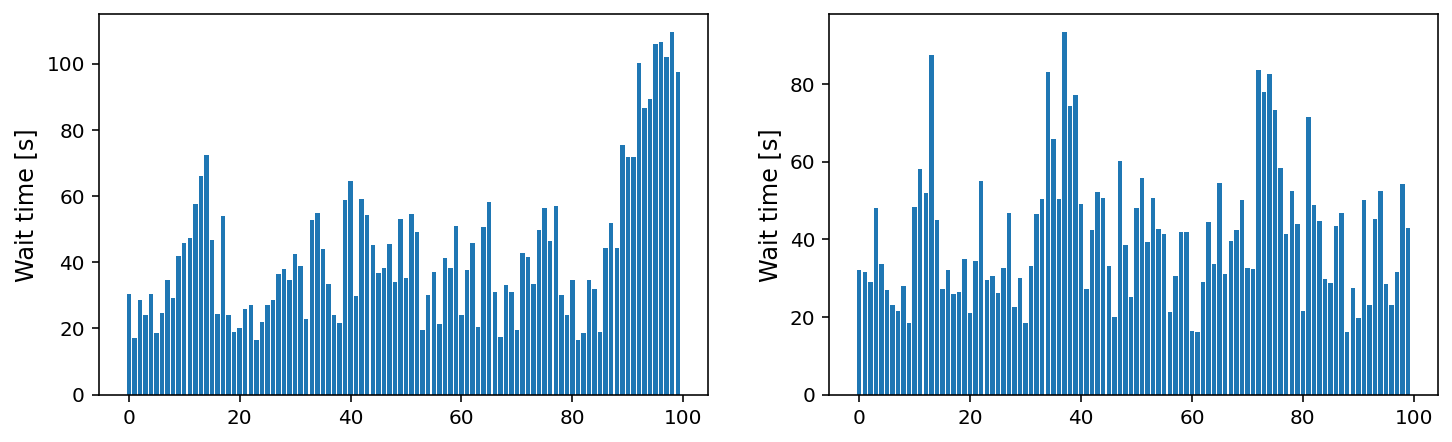

In [36]:
fix, axes = plt.subplots(ncols=2, figsize=(12, 3.5))
plot_wait_times(next(s_3_20), axes[0]);
plot_wait_times(next(s_3_20), axes[1]);

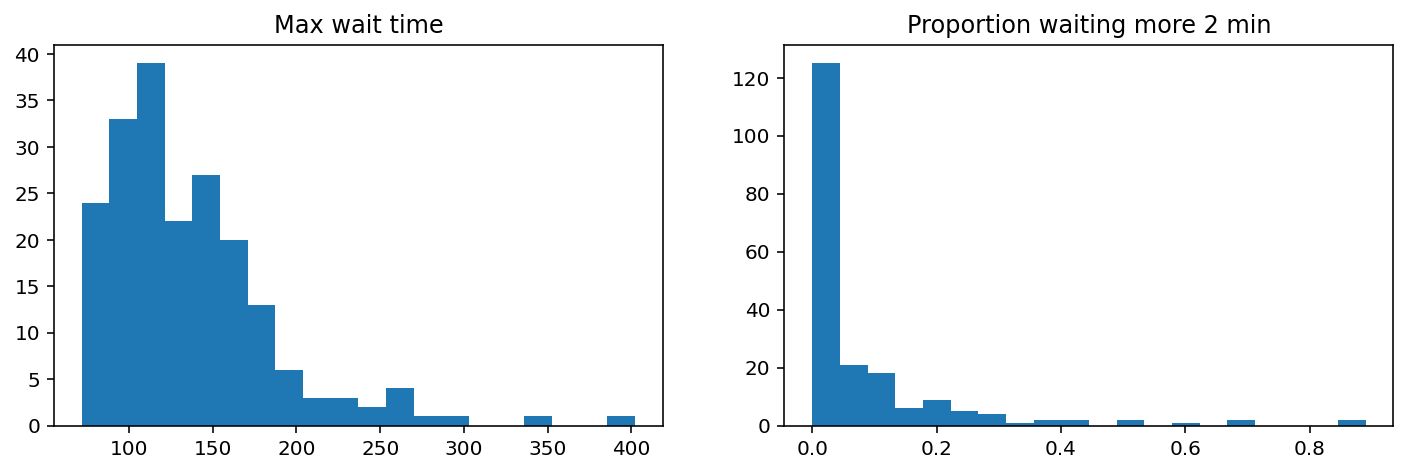

In [37]:
stats_3_20 = collect_stats(s_3_20, N_SIMUL, [np.max, prop_exceeds])
plot_stats(stats_3_20);

In [45]:
s_2_20 = simul_many_passengers_leave(n_elevs=2, n_passengers=N_PASSENGERS, interarrival=20)

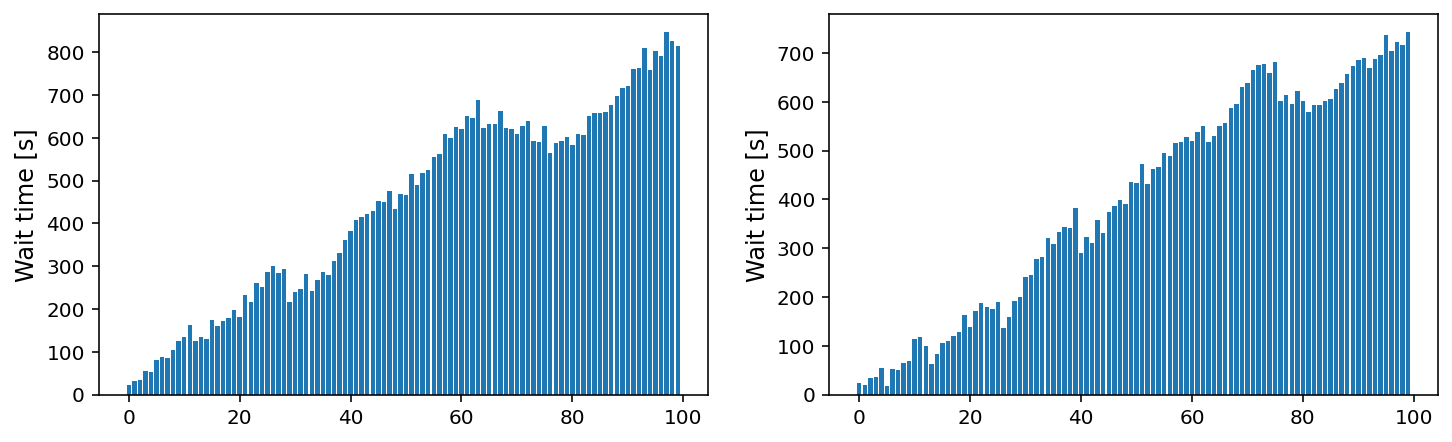

In [52]:
fix, axes = plt.subplots(ncols=2, figsize=(12, 3.5))
plot_wait_times(next(s_2_20), axes[0]);
plot_wait_times(next(s_2_20), axes[1]);

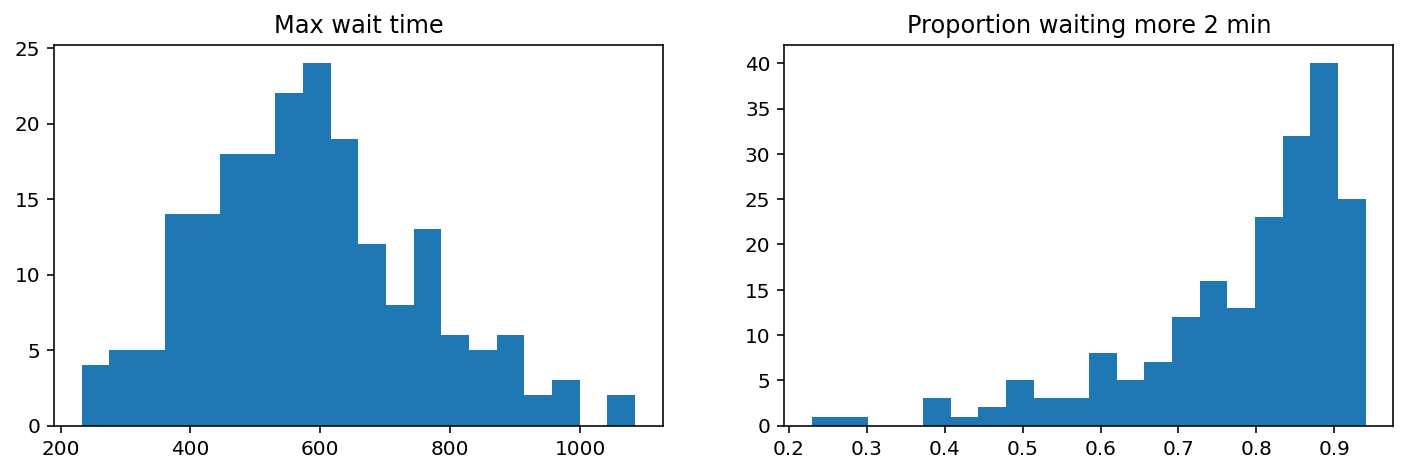

In [51]:
stats_2_20 = collect_stats(s_2_20, N_SIMUL, [np.max, prop_exceeds])
plot_stats(stats_2_20);

In [53]:
stats = {}
for interarr in range(10, 70, 10):
    simul = simul_many_passengers_leave(n_elevs=2, n_passengers=N_PASSENGERS, interarrival=interarr)
    stats[interarr] = collect_stats(simul, N_SIMUL, [np.max, prop_exceeds])

In [61]:
sns.boxplot([d[:, 1] for d in stats.values()], x=range(10, 70, 10));

/home/nikolay/.pyenv/versions/3.7.4/envs/main/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


TypeError: Horizontal orientation requires numeric `x` variable.